# Notebook tutorial for computing and plotting variance of Lagrangian and Eulerian velocity data  

by Eli Faigle (elijfaigle@gmail.com)

This notebook tutorial will walk through the analysis and calculations necessary to filter and estimate the oceanic KE for Figure 3 of Elipot et al. 2024 HYCOM-Oceantrack: Integrated HYCOM Eulerian Fields and Lagrangian Trajectories Dataset. The calculations use data from a small geographical region in order to limit the computation times to be practical in a Jupyter Notebook. To create Figure 3 from `figure3.ipynb`, the analysis in this notebook is elevated to a global scale.

# Library Import

In [1]:
 # computational import
import numpy as np
import xarray as xr
import scipy as sc
import dask.array as da
import zarr
# AWS import
import s3fs

# AWS S3 bucket file access set up:

In [2]:
# aws set up
bucket_name = 'hycom-global-drifters'

s3 = s3fs.S3FileSystem(anon=True)

In [3]:
# choose step and depth
step = 7
depth = 0
# define the path of the zarr store:
zarr_store_path = bucket_name+'/lagrangian/global_hycom_'+str(depth)+'m_step_'+str(step)+'.zarr'

In [4]:
# open dataset from bucket
ds = xr.open_zarr(s3.get_mapper(zarr_store_path), consolidated=True)

In [5]:
# view contents
ds

<xarray.Dataset>
Dimensions:     (traj: 593292, obs: 1440)
Coordinates:
    id          (traj) int64 dask.array<chunksize=(593292,), meta=np.ndarray>
  * obs         (obs) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
Dimensions without coordinates: traj
Data variables:
    depth       (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    grounding   (traj, obs) bool dask.array<chunksize=(93206, 1440), meta=np.ndarray>
    lat         (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    lon         (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    ssh         (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    steric_ssh  (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(9271, 45), meta=np.ndarray>
    ve          (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
    vn          (traj, obs) float32 dask.array<chunksize=(23301, 1440), meta=np.ndarray>
Attributes:
    feature_type:      trajectory
    parcels_mesh:      spherical
    parcels_versions:  2.4.1.dev9

# Selecting geographical region:
To select data within a dask array, you must first define and calculate a condition before applying it to the dataset.

In [6]:
# choose lon and lat bounds (in this case the Gulf of Mexico)
max_lat = 30
min_lat = 18
max_lon = -80
min_lon = -98

In [7]:
# create condition to apply to dask array
condition = ((ds['lon'] >= min_lon) & (ds['lon'] <= max_lon) & 
             (ds['lat'] >= min_lat) & (ds['lat'] <= max_lat))

In [8]:
# compute the condition
condition_computed = condition.compute()

In [9]:
# apply condition to dask array
ds1 = ds.where(condition_computed, drop=True)

In [10]:
# view new dataset
ds1

<xarray.Dataset>
Dimensions:     (traj: 5063, obs: 1440)
Coordinates:
    id          (traj) int64 175225 175228 175810 ... 289773 290932 290936
  * obs         (obs) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
Dimensions without coordinates: traj
Data variables:
    depth       (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
    grounding   (traj, obs) float64 dask.array<chunksize=(2807, 1440), meta=np.ndarray>
    lat         (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
    lon         (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
    ssh         (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
    steric_ssh  (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
    time        (traj, obs) datetime64[ns] dask.array<chunksize=(21, 45), meta=np.ndarray>
    ve          (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
    vn          (traj, obs) float32 dask.array<chunksize=(140, 1440), meta=np.ndarray>
Attributes:
    feature_type:      trajectory
    parcels_mesh:      spherical
    parcels_versions:  2.4.1.dev9

# Variance calculation:
Using scipy.stats.binned_statistic_2d(), the following code calculates velocity variance in 1/n degree bins. 

In [11]:
# mask the 'grounded' trajectories
ds1 = ds1.where(ds1['grounding'].compute() == False, drop=True)

In [12]:
# create complex velocity array
x = ds1.ve + 1j*ds1.vn

In [13]:
# define 1/n degree bins for stats_2d 
n = 8
lon = np.linspace(-180,180, 360*n)
lat = np.linspace(-90, 90, 180*n)

In [14]:
# take variance 
var = sc.stats.binned_statistic_2d(ds1.lon.to_numpy().flatten(), 
                                   ds1.lat.to_numpy().flatten(),
                                   x.to_numpy().flatten(),
                                   statistic = np.nanvar,
                                   bins= [lon,lat])


/Users/elifaigle/anaconda3/envs/shanevenv/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Degrees of freedom <= 0 for slice.
  stat = stat_func(np.array(bin_map[i]))


# Repeat process on Eulerian data:

In [15]:
# repeat process with eulerian data
# choose step and depth
step = 7
depth = 0
# define the path of the zarr store:
zarr_store_path = bucket_name+'/eulerian/hycom12-'+str(step)+'-rechunked-corr.zarr'
store = s3fs.S3Map(root=zarr_store_path, s3=s3)

In [16]:
# open dataset from bucket
ds2 = xr.open_zarr(store, consolidated="auto")

In [17]:
# view contents of eulerian dataset
ds2

<xarray.Dataset>
Dimensions:    (Depth: 2, Y: 7055, X: 9000, time: 720)
Coordinates:
  * Depth      (Depth) float32 0.0 15.0
    Latitude   (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
    Longitude  (Y, X) float32 dask.array<chunksize=(7055, 9000), meta=np.ndarray>
  * X          (X) int32 1 2 3 4 5 6 7 8 ... 8994 8995 8996 8997 8998 8999 9000
  * Y          (Y) int32 1 2 3 4 5 6 7 8 ... 7049 7050 7051 7052 7053 7054 7055
  * time       (time) datetime64[ns] 2014-06-30T01:00:00 ... 2014-07-30
Data variables:
    u          (time, Depth, Y, X) float32 dask.array<chunksize=(720, 1, 1, 9000), meta=np.ndarray>
    v          (time, Depth, Y, X) float32 dask.array<chunksize=(720, 1, 1, 9000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf3z
    source:       HYCOM archive file
    title:        HYCOM

In [18]:
# create condition to apply to dask array
condition = ((ds2['Depth'] == depth) & 
            (ds2['Longitude'] >= min_lon) & (ds2['Longitude'] <= max_lon) & 
            (ds2['Latitude'] >= min_lat) & (ds2['Latitude'] <= max_lat))

In [19]:
# compute the condition
condition_computed = condition.compute()

In [20]:
# apply condition to dask array
ds3 = ds2.where(condition_computed, drop=True)

In [21]:
# view new dataset
ds3

<xarray.Dataset>
Dimensions:    (time: 720, Depth: 1, Y: 407, X: 501)
Coordinates:
  * Depth      (Depth) float32 0.0
    Latitude   (Y, X) float32 15.02 15.02 15.02 15.02 ... 29.97 29.97 29.97
    Longitude  (Y, X) float32 -100.0 -99.96 -99.92 ... -80.08 -80.04 -80.0
  * X          (X) int32 4647 4648 4649 4650 4651 ... 5143 5144 5145 5146 5147
  * Y          (Y) int32 3849 3850 3851 3852 3853 ... 4251 4252 4253 4254 4255
  * time       (time) datetime64[ns] 2014-06-30T01:00:00 ... 2014-07-30
Data variables:
    u          (time, Depth, Y, X) float32 dask.array<chunksize=(720, 1, 1, 501), meta=np.ndarray>
    v          (time, Depth, Y, X) float32 dask.array<chunksize=(720, 1, 1, 501), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    experiment:   10.2
    history:      archv2ncdf3z
    source:       HYCOM archive file
    title:        HYCOM

In [22]:
# create complex velocity array
x2 = ds3.u + 1j*ds3.v

Because of the organization of the Eulerian data, the variance of the complex velocity array must be taken with np.nanvar before averaging those results in 1/n degree lat and lon bins with scipy_stats_binned_statistic_2d().

In [24]:
# take variance of complex velocity array
y = np.nanvar(x2, axis = 0)

/var/folders/sp/w25h36ts7mjblxp7wdbshfvm0000gn/T/ipykernel_49225/1497128268.py:2: RuntimeWarning: Degrees of freedom <= 0 for slice.
  y = np.nanvar(x2, axis = 0)


In [25]:
# average the variance in lon and lat bins
var2 = sc.stats.binned_statistic_2d(ds3.Longitude.to_numpy().flatten(), 
                                   ds3.Latitude.to_numpy().flatten(),
                                   y.flatten(),
                                   statistic = np.nanmean,
                                   bins= [lon,lat])

/Users/elifaigle/anaconda3/envs/shanevenv/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


# Save data in an xarray dataset format:

In [26]:
# create a dataset to store calculations
ds4 = xr.Dataset(data_vars=dict(lag_var = (['lon','lat'], var.statistic.real),
                             eul_var = (['lon','lat'], var2.statistic.real),),
              coords = dict(lon = var.x_edge[0:-1], lat = var.y_edge[0:-1]),)

# save dataset
ds4.to_netcdf('step_7_var.nc')


In [27]:
# view variance dataset
ds4

<xarray.Dataset>
Dimensions:  (lon: 2879, lat: 1439)
Coordinates:
  * lon      (lon) float32 -180.0 -179.9 -179.7 -179.6 ... 179.6 179.7 179.9
  * lat      (lat) float32 -90.0 -89.87 -89.75 -89.62 ... 89.5 89.62 89.75 89.87
Data variables:
    lag_var  (lon, lat) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eul_var  (lon, lat) float64 nan nan nan nan nan nan ... nan nan nan nan nan

# Plot data:
Because the data analyzed in this notebook comes from the Gulf of Mexico, the plots have been slightly changed from Figure 3 to be the ccrs.PlateCaree() projection zoomed in on the Gulf of Mexico.

In [28]:
# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cmocean

In [29]:
# import datelist
dlist = ['31-Jan-2014','02-Mar-2014','01-Apr-2014','01-May-2014','31-May-2014','30-Jun-2014',
    '30-Jul-2014','29-Aug-2014','28-Sep-2014','28-Oct-2014','27-Nov-2014']

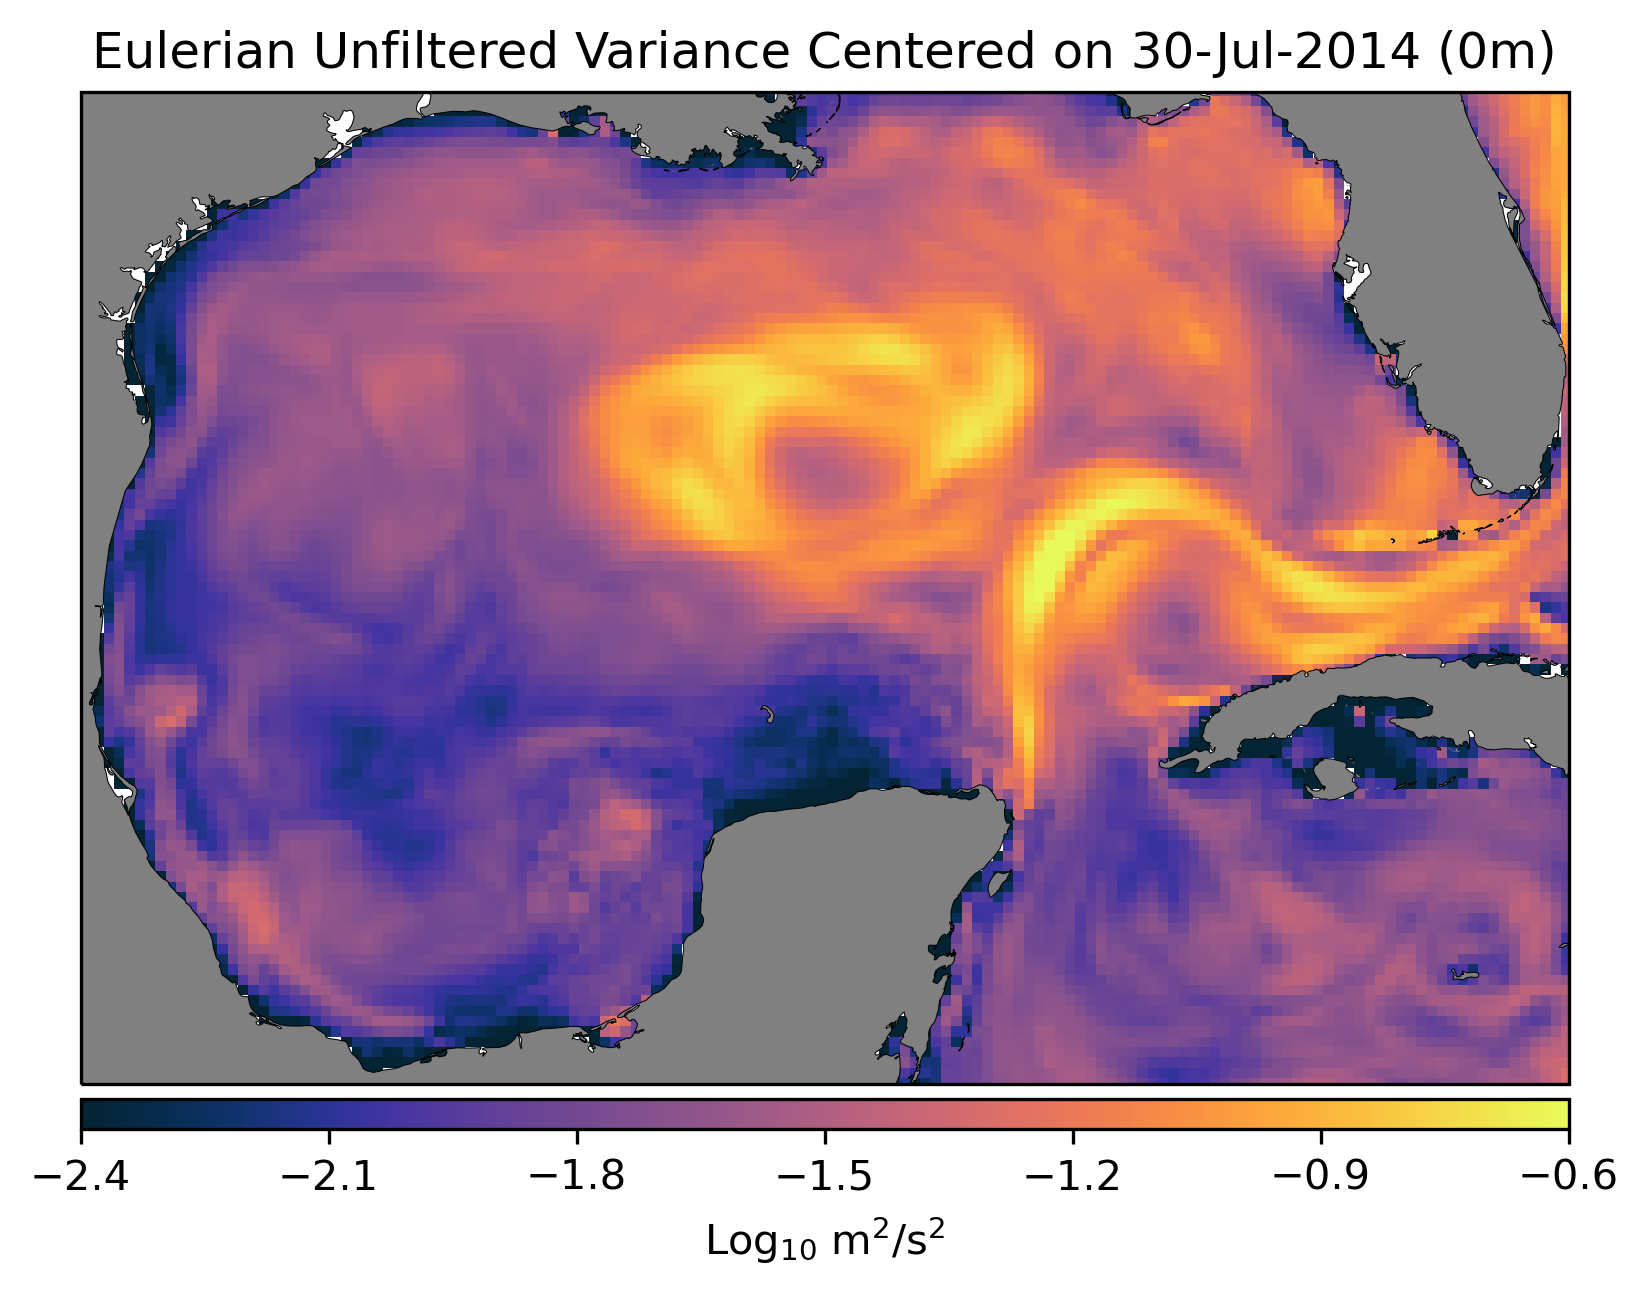

In [33]:
# create colormap
cmap = plt.colormaps.get_cmap('cmo.thermal')

# create figure and axis
fig1 = plt.figure(dpi=300)
ax1 = fig1.add_subplot(1,1,1,projection=ccrs.PlateCarree())

# create image
image = plt.pcolormesh(lon, lat,
        np.log10((ds4['eul_var'].transpose())), 
        cmap=cmap, 
        transform=ccrs.PlateCarree(),
        vmin=-2.4, vmax=-0.6) 

# set the extent to the coordinates of the Gulf of Mexico
ax1.set_extent([-98, -80, 18, 30])

# gridlines and labels
gl = ax1.gridlines(color='k', linewidth=0.1, linestyle='-',
        xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
        draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False

# add land and coastline
ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0.05, axes_class=plt.Axes)

# create colorbar
cb = fig1.colorbar(image, cax=cax, orientation = "horizontal", ticks = np.linspace(-2.4, -0.6, 7));
cb.ax.set_xlabel('Log$_{10}$ m$^{2}$/s$^{2}$');

# set title and save image
ax1.set_title('Eulerian Unfiltered Variance Centered on '+dlist[int(step-1)]+' (0m)')
plt.savefig('eulerian_var.pdf', dpi=300)

/Users/elifaigle/anaconda3/envs/shanevenv/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


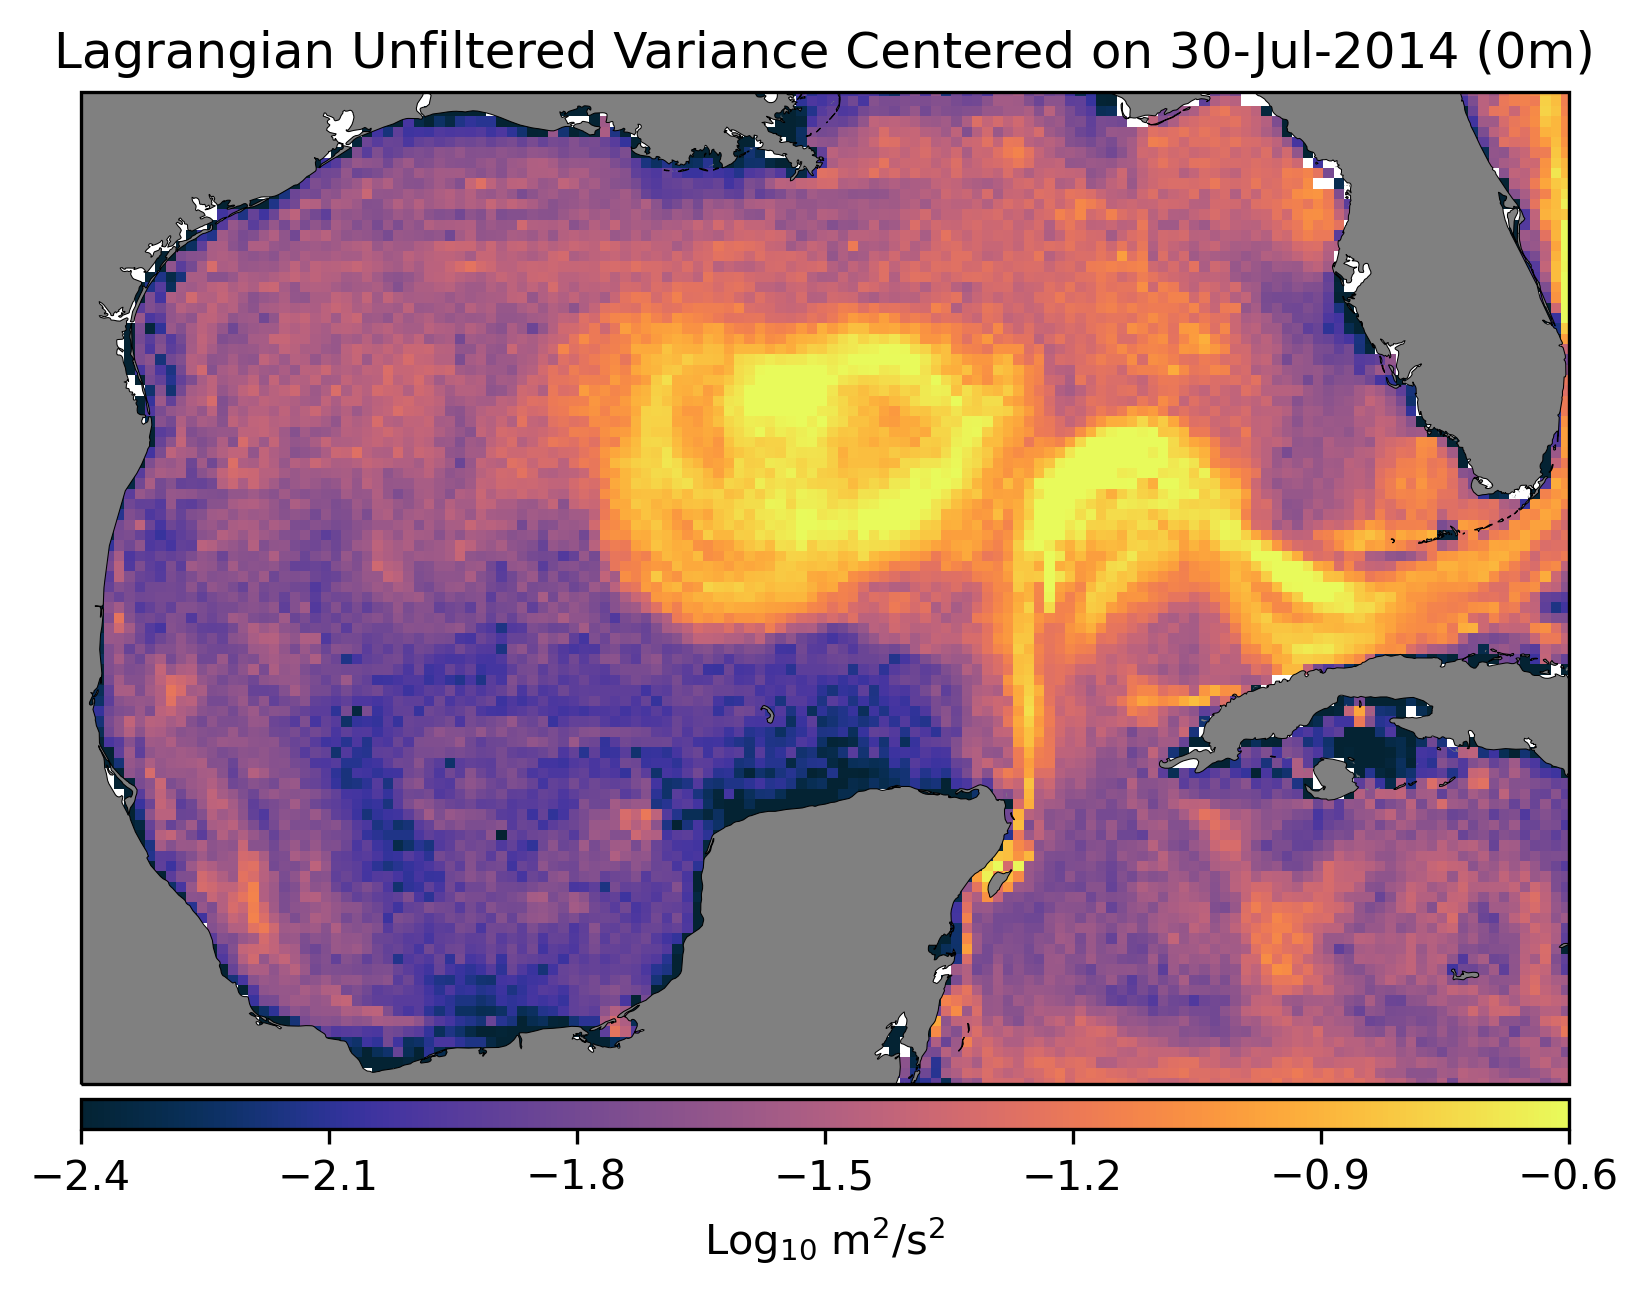

In [31]:
# create colormap
cmap = plt.colormaps.get_cmap('cmo.thermal')

# create figure and axis
fig1 = plt.figure(dpi=300)
ax1 = fig1.add_subplot(1,1,1,projection=ccrs.PlateCarree())

# create image
image = plt.pcolormesh(lon, lat,
        np.log10((ds4['lag_var'].transpose())), 
        cmap=cmap, 
        transform=ccrs.PlateCarree(),
        vmin=-2.4, vmax=-0.6) 

# set the extent to the coordinates of the Gulf of Mexico
ax1.set_extent([-98, -80, 18, 30])

# gridlines and labels
gl = ax1.gridlines(color='k', linewidth=0.1, linestyle='-',
        xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90, 91, 30),
        draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False

# add land and coastline
ax1.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0.05, axes_class=plt.Axes)

# create colorbar
cb = fig1.colorbar(image, cax=cax, orientation = "horizontal", ticks = np.linspace(-2.4, -0.6, 7));
cb.ax.set_xlabel('Log$_{10}$ m$^{2}$/s$^{2}$');

# set title and save image
ax1.set_title('Lagrangian Unfiltered Variance Centered on '+dlist[int(step-1)]+' (0m)')
plt.savefig('lagrangian_var.pdf', dpi=300)